In [1]:
# importing system libraries
from os import walk
import pandas as pd
import numpy as np
import sklearn as sk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kseneya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Подготовка датасета для обучения

In [2]:
# Read the whole data from the Enron Dataset into a variable allData.

pathwalk = walk(r"archive/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))

# remove all redundent data

allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# storing it in a dataframe

hamPlusSpamData = allHamData + allSpamData
labels = ["ham"]*len(allHamData) + ["spam"]*len(allSpamData)

raw_df = pd.DataFrame({"email": hamPlusSpamData,
                       "label": labels})

# label encoding the labels

label_encoder = sk.preprocessing.LabelEncoder()
raw_df['label'] = label_encoder.fit_transform(raw_df.label)

# split
X_train = raw_df['email']
y_train = raw_df['label']

Пайплайн обучения с поиском лучшей модели

In [5]:
# add stemmer
class StemTokenizer(object):
    """
    StemTokenizer tokenizes words, removes stopwords, preprocess and stems words
    in each document.
    """
    def __init__(self, remove_stop_words: bool = True, stemmer = SnowballStemmer(language='english')):

        self.stop_words = set()
        if remove_stop_words:
            self.stop_words = set(stopwords.words('english'))
        self.stemmer    = stemmer

    def __call__(self, doc):
        review = re.sub(r'\\r\\n', ' ', doc)
        # Remove all symbols except letters
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Replacing all gaps with spaces
        review = re.sub(r'\s+', ' ', review)
        # Remove 'b' in the beginning of each text
        review = re.sub(r'^b\s+', '', review)
        review = review.lower()
        review = review[review.startswith('subject') and len('subject'):]

        unfiltered_tokens = (self.stemmer.stem(token)
                             for token in word_tokenize(review.replace("\n", " "))
                             if token not in self.stop_words)

        return list(filter(lambda x : len(x) > 1, unfiltered_tokens))


# add lemmatizer
class LemmaTokenizer(object):
    """
    LemmaTokenizer tokenizes words, removes stopwords, preprocess and lemmatizes words
    in each document.
    """
    def __init__(self, remove_stop_words: bool = True, lemmatizer = WordNetLemmatizer()):

        self.stop_words = set()
        if remove_stop_words:
            self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = lemmatizer


    def __call__(self, doc):
        review = re.sub(r'\\r\\n', ' ', doc)
        # Remove all symbols except letters
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Replacing all gaps with spaces
        review = re.sub(r'\s+', ' ', review)
        # Remove 'b' in the beginning of each text
        review = re.sub(r'^b\s+', '', review)
        review = review.lower()
        review = review[review.startswith('subject') and len('subject'):]

        unfiltered_tokens = (self.lemmatizer.lemmatize(token)
                             for token in word_tokenize(review.replace("\n", " "))
                             if token not in self.stop_words)

        return list(filter(lambda x : len(x) > 1, unfiltered_tokens))


# add simple stop word tokenizer
class StopWordTokenizer(object):
    """
    StopWordsTokenizer tokenizes words and removes stopwords that are
    passed in through the constructor.
    """
    def __init__(self, remove_stop_words: bool = True):
        self.stop_words = set()
        if remove_stop_words:
            self.stop_words = set(stopwords.words('english'))
        self.pattern    = re.compile('[\W_]+',re.UNICODE)

    def __call__(self, doc):
        unfiltered_tokens = (self.pattern.sub("",token) for token in word_tokenize(doc.replace("\n", " "))
                             if token not in self.stop_words)

        return list(filter(lambda x : len(x) > 1, unfiltered_tokens))

In [83]:
# create model pipeline
model_pipeline  = Pipeline([('vect',    CountVectorizer()),
                       ('model',   LogisticRegression())])

optimization_grid = []


# Multinomial NB
optimization_grid.append({
    'vect': [TfidfVectorizer(), CountVectorizer()],
    'vect__tokenizer': (
        StopWordTokenizer(),
        StemTokenizer(),
        StemTokenizer(stemmer=PorterStemmer()),
        LemmaTokenizer() ),
    'model': [MultinomialNB()]
})


# Logistic regression
optimization_grid.append({
    'vect': [TfidfVectorizer(), CountVectorizer()],
    'vect__tokenizer': (StopWordTokenizer(), StemTokenizer(), LemmaTokenizer()),
    'model': [LogisticRegression()],
    'model__penalty': ['l2', 'l1']
})


# Random Forest
optimization_grid.append({
    'vect': [TfidfVectorizer(), CountVectorizer()],
    'vect__tokenizer': (StopWordTokenizer(), StemTokenizer(), LemmaTokenizer()),
    'model': [RandomForestClassifier(random_state=0)],
    'model__n_estimators': np.arange(5, 300, 40),
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_features': ['sqrt', 'log2']
})


# Linear SVM
optimization_grid.append({
    'vect': [TfidfVectorizer(), CountVectorizer()],
    'vect__tokenizer': (StopWordTokenizer(), StemTokenizer(), LemmaTokenizer()),
    'model': [LinearSVC(random_state=50)],
    'model__penalty': ['l1', 'l2'],
    'model__C': np.arange(0.1, 1, 0.1),
})


search = GridSearchCV(
            model_pipeline,
            optimization_grid,
            # scoring='precision',
            scoring = 'balanced_accuracy',
            # error_score='raise',
            cv = 3,
            # n_jobs= -1
        )

In [ ]:
search.fit(X_train, y_train)

In [85]:
search.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<__main__.StopWordTokenizer object at 0x15a7cda30>)),
                ('model', LogisticRegression())])

In [86]:
search.best_params_

{'model': LogisticRegression(),
 'model__penalty': 'l2',
 'vect': CountVectorizer(tokenizer=<__main__.StopWordTokenizer object at 0x15592e0d0>),
 'vect__tokenizer': <__main__.StopWordTokenizer at 0x15592e0d0>}

In [87]:
pd.concat([pd.DataFrame(search.cv_results_["params"]),
                                       pd.DataFrame(search.cv_results_["mean_test_score"], columns=['balanced_accuracy'])], axis=1).sort_values('balanced_accuracy', ascending=False).head(3)



model model__penalty  \
3  LogisticRegression()             l2   
5  LogisticRegression()             l2   
0  LogisticRegression()             l2   

                                                vect  \
3  CountVectorizer(tokenizer=<__main__.StopWordTo...   
5  CountVectorizer(tokenizer=<__main__.StopWordTo...   
0                                  TfidfVectorizer()   

                                     vect__tokenizer  balanced_accuracy  
3  <__main__.StopWordTokenizer object at 0x15592e...           0.987669  
5    <__main__.LemmaTokenizer object at 0x156db8580>           0.986483  
0  <__main__.StopWordTokenizer object at 0x15592e...           0.985815

Подготовка тестового датасета, скачанного по ссылке

In [88]:
from email import message_from_file, message_from_binary_file


def pullout(m, key):
    """Extracts content from an e-mail message.
    This works for multipart messages too.
    m   -- email.Message() or mailbox.Message()
    key -- Initial message ID (some string)
    Returns
    Html  -- All HTMLs or text from all parts
    """
    Html = ""

    if not m.is_multipart():

        cp = m.get_content_type()

        if cp=="text/plain" or cp=="text/html":
            Html += str(m.get_payload(decode=True).decode())

        return Html
    # This IS a multipart message.
    # So, we iterate over it and call pullout() recursively for each part.
    y = 0

    while 1:
        # If we cannot get the payload, it means we hit the end:
        try:
            pl = m.get_payload(y)
        except: break
        # pl is a new Message object which goes back to pullout
        h = pullout(pl, key)
        Html += h
        y += 1
    return Html


def extract(msgfile, key):
    """Extracts all data from e-mail, including From, To, etc., and returns it as a dictionary.
    msgfile -- A file-like readable object
    key     -- Some ID string for that particular Message. Can be a file name or anything.
    Returns dict()
    Keys: from, to, subject, date, html
    """

    try:
        m = message_from_binary_file(msgfile)
    except AttributeError:
        m = message_from_file(msgfile)

    From, To, Subject, Date = caption(m)
    Html = pullout(m, key)
    Html = Html.strip()

    msg = {"subject": Subject, "from": From, "to": To, "date": Date, "html": Html}

    return msg


def caption(origin):
    """Extracts: To, From, Subject and Date from email.Message() or mailbox.Message()
    origin -- Message() object
    Returns tuple(From, To, Subject, Date)
    If message doesn't contain one/more of them, the empty strings will be returned.
    """
    Date = ""
    if "date" in origin: Date = origin["date"].strip()
    From = ""
    if "from" in origin: From = origin["from"].strip()
    To = ""
    if "to" in origin: To = origin["to"].strip()
    Subject = ""
    if "subject" in origin: Subject = origin["subject"].strip()
    return From, To, Subject, Date

In [ ]:
# create spam and ham datasets
import os
from bs4 import BeautifulSoup
import pandas as pd

def create_dataset(type_df):
    df = pd.DataFrame(columns = ['email', 'label'])

    path = f'/Users/kseneya/spam_detection/{type_df}/'
    listing = os.listdir(path)

    for fle in listing:
        if str.lower(fle[-3:])=="eml":
            try:
                f = open(f"{path}{fle}", "rb")
                result = extract(f, f.name)

                # Initializing variable
                gfg = BeautifulSoup(result['html'])

                # Calculating result
                res = gfg.get_text()
                res = res.replace('\n', ' ').replace('\\n', ' ')
                res = " ".join(res.split())

                artist = dict()
                artist['email'] = result['subject'] + ' ' + res
                artist['label'] = type_df
                df = df.append(artist, ignore_index=True)
            except:
                pass
    return df

spam = create_dataset('spam')
ham = create_dataset('ham')

In [90]:
# concat spam and ham
test_df = pd.concat([spam, ham])

# encoding label
test_df['label'] = label_encoder.transform(test_df.label)

X_test = test_df['email']
y_test = test_df['label']

In [91]:
test_df

email  label
0    Prescriptions Without Doctors Appointment!! Th...      1
1    eBay ordering8932 "Finally - You Too Can Make ...      1
2    (_) Increase Your Sales!!!! Dear Consumers, In...      1
3    yyyy,Do You Know the HGH Differences ? Hello, ...      1
4    An Information An I n f o r m a t i o n An I n...      1
..                                                 ...    ...
554  Re: AA Meetings the Hottest Place to Meet Wome...      0
555  Re: erratum [Re: no matter ...] & errors > I'm...      0
556  Re: New Sequences Window >>>Robert Elz said: >...      0
557  Re: Hanson's Sept 11 message in the National R...      0
558  Re[2]: Goodbye Global Warming How about this: ...      0

[1339 rows x 2 columns]

Проверка обученной модели на тестовом датасете

In [92]:
y_pred = search.predict(X_test)

In [93]:
from sklearn.metrics import confusion_matrix

In [94]:
confusion_matrix(y_true= y_test, y_pred = y_pred)

array([[182, 377],
       [ 23, 757]])

In [95]:
precision_score(y_true= y_test, y_pred = y_pred)

0.6675485008818343

In [96]:
recall_score(y_true= y_test, y_pred = y_pred)

0.9705128205128205

Корректировка трешхолда для получения большего показателя precision
Примем условия:
* precision > 0.95
* максимизировать recall

In [97]:
prec, rec, thresholds = precision_recall_curve(y_true= y_test,
                                               probas_pred = search.predict_proba(X_test.to_frame()['email'])[:,1])

/Users/kseneya/spam_detection/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


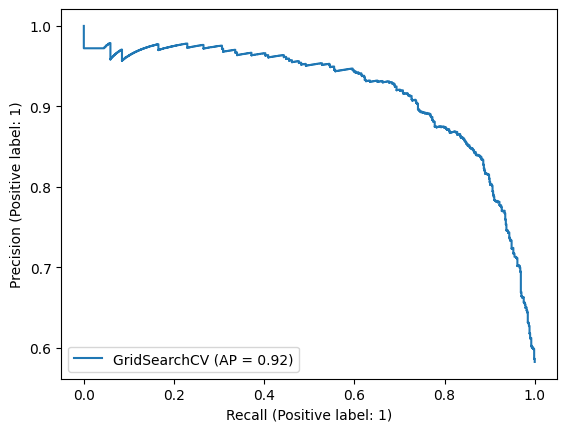

In [98]:
plot_precision_recall_curve(estimator = search, X = X_test, y = y_test)

In [99]:
np.where(prec > 0.95)

(array([ 851,  852,  853,  854,  855,  856,  857,  858,  859,  860,  861,
         862,  863,  864,  865,  866,  867,  868,  869,  870,  871,  872,
         873,  874,  875,  876,  877,  878,  879,  880,  881,  882,  883,
         884,  885,  886,  887,  888,  889,  890,  891,  892,  893,  894,
         895,  896,  897,  898,  899,  900,  901,  902,  903,  904,  905,
         906,  907,  908,  909,  910,  911,  912,  913,  914,  915,  916,
         917,  918,  919,  920,  921,  922,  923,  924,  925,  926,  927,
         928,  929,  930,  931,  932,  933,  934,  935,  936,  937,  938,
         939,  940,  941,  942,  943,  944,  945,  946,  947,  948,  949,
         950,  951,  952,  953,  954,  955,  956,  957,  958,  959,  960,
         961,  962,  963,  964,  965,  966,  967,  968,  969,  970,  971,
         972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,
         983,  984,  985,  986,  987,  988,  989,  990,  991,  992,  993,
         994,  995,  996,  997,  998, 

In [110]:
precision_score(y_true= y_test, y_pred = search.predict_proba(X_test.to_frame()['email'])[:,1] > thresholds[851])

0.9507829977628636

In [108]:
recall_score(y_true= y_test, y_pred = search.predict_proba(X_test.to_frame()['email'])[:,1] > thresholds[851])

0.5448717948717948

In [109]:
confusion_matrix(y_true= y_test, y_pred = search.predict_proba(X_test.to_frame()['email'])[:,1] > thresholds[851])

array([[537,  22],
       [355, 425]])